## Import 

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds



2023-06-09 10:17:43.625389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 10:17:43.893620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-09 10:17:43.893637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-09 10:17:43.932306: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-09 10:17:44.828529: W tensorflow/stream_executor/platform/de

In [4]:
import matplotlib.pyplot as plt
import pandas as pd


## Load Data

In [5]:
data_dir = '../raw_data'

dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode='grayscale',
    batch_size=32, 
    image_size=(256, 256), 
    shuffle=True, 
    labels
    seed=42 
)

Found 55448 files belonging to 39 classes.


2023-06-09 10:17:49.525310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-09 10:17:49.525512: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-09 10:17:49.525534: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chinzi-Latitude-5510): /proc/driver/nvidia/version does not exist
2023-06-09 10:17:49.526994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [104]:
def download_data(path=None, batch_size=32, image_size=(256,256),shuffle=True, testratio=0.9, valratio=0.8, color_mode='rgba') :

    if path == None :
        data_dir = '../raw_data'
    else :
        data_dir = path

    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=image_size,
        color_mode=color_mode,
        shuffle=shuffle,
        seed=42 )
    train_val_ds = dataset.take(round(len(dataset) * testratio))  # 90% pour l'entraînement
    test_ds = dataset.skip(round(len(dataset) * testratio))  # 10% pour le test

    train_ds = dataset.take(round(len(train_val_ds) * valratio))  # 90% pour l'entraînement
    val_ds = dataset.skip(round(len(train_val_ds) * valratio))  # 10% pour le test

    print("✅ data loaded")

    return train_ds , test_ds , val_ds


In [105]:
train_ds , val_ds ,test_ds = download_data(color_mode='rgb')

Found 55448 files belonging to 39 classes.
✅ data loaded


In [42]:
val_ds.image_size()

AttributeError: 'SkipDataset' object has no attribute 'image_size'

In [6]:
train_val_ds = dataset.take(round(len(dataset) * 0.9))  # 90% pour l'entraînement
test_ds = dataset.skip(round(len(dataset) * 0.9))  # 10% pour le test

In [7]:
train_ds = train_val_ds.take(round(len(train_val_ds) * 0.8))  # 80% pour l'entraînement
val_ds = train_val_ds.skip(round(len(train_val_ds) * 0.8))  # 20% pour le test

In [8]:
val_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=312>

In [42]:
index_dict={key:value for key, value in zip(dataset.class_names, range(40))}

In [43]:
index_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Background_without_leaves': 4,
 'Blueberry___healthy': 5,
 'Cherry___Powdery_mildew': 6,
 'Cherry___healthy': 7,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8,
 'Corn___Common_rust': 9,
 'Corn___Northern_Leaf_Blight': 10,
 'Corn___healthy': 11,
 'Grape___Black_rot': 12,
 'Grape___Esca_(Black_Measles)': 13,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
 'Grape___healthy': 15,
 'Orange___Haunglongbing_(Citrus_greening)': 16,
 'Peach___Bacterial_spot': 17,
 'Peach___healthy': 18,
 'Pepper,_bell___Bacterial_spot': 19,
 'Pepper,_bell___healthy': 20,
 'Potato___Early_blight': 21,
 'Potato___Late_blight': 22,
 'Potato___healthy': 23,
 'Raspberry___healthy': 24,
 'Soybean___healthy': 25,
 'Squash___Powdery_mildew': 26,
 'Strawberry___Leaf_scorch': 27,
 'Strawberry___healthy': 28,
 'Tomato___Bacterial_spot': 29,
 'Tomato___Early_blight': 30,
 'Tomato___Late_blight': 31,
 'Tomato__

In [97]:
shape= train_ds.element_spec[0].shape

# Convertir en tuple
new_shape = tuple(shape.as_list()[1:])


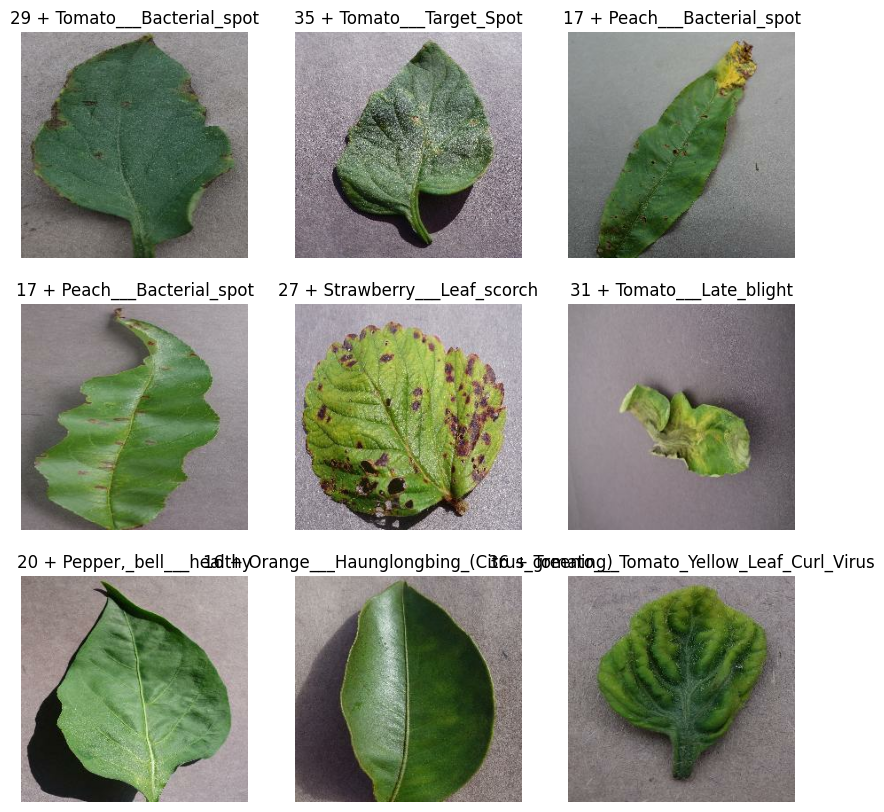

In [106]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(f'{labels[i]} + {dataset.class_names[labels[i]]}')
        plt.axis("off")

## Model

In [107]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=new_shape),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.CenterCrop(height=224, width=224), 
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(246, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(39, activation='softmax')
])

In [99]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 center_crop_9 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_9 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 conv2d_18 (Conv2D)          (None, 221, 221, 64)      3136      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                  

In [108]:
initial_learning_rate = 0.0015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,  
    decay_rate=0.9  
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [109]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [110]:
from tensorflow.keras.callbacks import EarlyStopping


es = EarlyStopping(patience=3, restore_best_weights=True)


In [111]:
model.fit(train_ds,
          callbacks=es,
          validation_data=val_ds,
          epochs=2)

Epoch 1/2
   3/1248 [..............................] - ETA: 34:52 - loss: 11.0538 - accuracy: 0.0312

KeyboardInterrupt: 

In [31]:
model.evaluate(test_ds)

170/170 [==============================] - 4s 24ms/step - loss: 0.6191 - accuracy: 0.8109


[0.6190786361694336, 0.810865581035614]

## Transfer Learning 

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense

# Charger le modèle VGG16 pré-entraîné
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Ajouter une couche Dense supplémentaire
x = base_model.output
x = Dense(256, activation='relu')(x)
predictions = Dense(38, activation='softmax')(x)

# Créer le nouveau modèle en spécifiant les couches d'entrée et de sortie
model = Model(inputs=base_model.input, outputs=predictions)

# Visualiser l'architecture du nouveau modèle
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5


InvalidArgumentError: ignored